# pusab

In [1]:
import json

with open('pusab2024/result.json') as f:
    my_json = json.load(f)

In [2]:
import pandas as pd
my_keys = set()
emojis = set()
hashtags = set()
for message in my_json['messages']:
    if pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06"):
        my_keys = my_keys.union(set(message.keys()))
        if ('reactions' in message) and (len(message['reactions']) >0):
            for rxn in message['reactions']:
                emojis.add(rxn['emoji'])
        if ('text_entities' in message) and (len(message['text_entities'] )> 0):
            hashtags = hashtags.union(set([i['text'] for i in message['text_entities'] if i['type']=='hashtag']))


In [3]:
import pandas as pd
from collections import defaultdict
import numpy as np

res_dict = defaultdict(list)
emoji_dict = defaultdict(list)
hashtag_dict = defaultdict(list)

for message in my_json['messages']:
    
    if (pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06")) and (pd.to_datetime(message['date']) > pd.to_datetime("2024-01-01")) and (message['type']=='message'):
        for k, v in message.items():
            res_dict[k].append(str(v))
        text_plain = ''.join([i['text'] for i in message['text_entities'] if (i['type']!='hashtag') and (i['type']!='mention')])
        if ('photo' in message) and (pd.notnull(message['photo'])):
            text_plain = "media_image\n" + text_plain
        if ('media_type' in message):
            if message['media_type'] == 'video_file':
                text_plain = "media_video\n" + text_plain
            if message['media_type'] == 'voice_message':
                text_plain = "media_audio\n" + text_plain
        res_dict['text_plain'].append(text_plain)
        un_list = [i for i in my_keys if i not in message]
        for i in un_list:
            res_dict[i].append(np.nan)
        
        temp_emojis = dict()
        emoji_dict['id'].append(message['id'])
        if ('reactions' in message) and (len(message['reactions']) > 0):
            temp_emojis = {i['emoji']:i['count'] for i in message['reactions']}
        
        for k, v in temp_emojis.items():
            emoji_dict[k].append(v)
        un_emojis = [i for i in emojis if i not in temp_emojis]
        for i in un_emojis:
            emoji_dict[i].append(np.nan)
        
        temp_hashs = set()
        hashtag_dict['id'].append(message['id'])
        if ('text_entities' in message) and (len(message['text_entities']) > 0):
            for j in [i['text'] for i in message['text_entities'] if i['type']=='hashtag']:
                if j not in temp_hashs:
                    temp_hashs.add(j)
                    hashtag_dict[j].append(1)
        un_hashs = [i for i in hashtags if i not in temp_hashs]
        for i in un_hashs:
            hashtag_dict[i].append(np.nan)

In [4]:
result_df = pd.DataFrame(res_dict)
result_df = result_df[result_df['text_plain'].apply(len)>0].reset_index(drop=True)
result_df['id'] = result_df['id'].astype(int)
result_df['date'] = pd.to_datetime(result_df['date'])

emoji_df = pd.DataFrame(emoji_dict)
emoji_df['id'] = emoji_df['id'].astype(int)

hashtag_df = pd.DataFrame(hashtag_dict)
hashtag_df['id'] = hashtag_df['id'].astype(int)


result_df['num_reactions'] = result_df['id'].map(emoji_df.set_index('id').sum(axis=1).to_dict())
result_df['weights'] = np.sqrt(result_df['num_reactions']+1).astype(int)

In [5]:
from bnlp import NLTKTokenizer, BengaliCorpus
from bangla_stemmer.stemmer.stemmer import BanglaStemmer
import os
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from contextlib import redirect_stdout

snowball_stemmer = nltk.stem.SnowballStemmer('english')

stemmer = BanglaStemmer()

# bnltk_tokenizer = NLTKTokenizer()
twt_tokenizer = TweetTokenizer()

ignore_words = stopwords.words('english') + BengaliCorpus.stopwords + list(BengaliCorpus.punctuations) + ['➡', "", "click", "..", "..."]

def process_texts(x):
    x = x.lower().replace("।", "")
    
    nltk_tokens = twt_tokenizer.tokenize(x)
    filtered_nltk_tokens = [i for i in nltk_tokens if (i not in ignore_words) and (len(i.strip())> 1)]
    # filtered_tokens = [i for i in stemmed_tokens if i not in BengaliCorpus.stopwords]
    stemmed_tokens = [snowball_stemmer.stem(i) for i in filtered_nltk_tokens]
    # x = " ".join(stemmed_tokens)
    
    
    # tokens = bnltk_tokenizer.word_tokenize(x)
    
    with open(os.devnull, 'w') as f:
        with redirect_stdout(f):
            stemmed_tokens = [stemmer.stem(i) for i in stemmed_tokens]
    
    return [i for i in stemmed_tokens if len(i) >0]



result_df['documents'] = result_df['text_plain'].apply(process_texts)


result_df['documents']=result_df['documents'].apply(lambda x: [i for i in x if len(i)>1])


punkt not found. downloading...


[nltk_data] Downloading package punkt_tab to /home/fahim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/home/fahim/miniconda3/envs/llm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel


result_df_subset = result_df[result_df['documents'].apply(len)>0].reset_index(drop=True)

dictionary = Dictionary(result_df_subset['documents'])


weighted_corpus = []
for i, text in enumerate(result_df_subset['documents']):
    bow = dictionary.doc2bow(text)
    weighted_bow = []
    for word_id, count in bow:
        weighted_bow.append((word_id, count * result_df_subset['weights'].iloc[i]))
    weighted_corpus.append(weighted_bow)

lda_model = LdaModel(weighted_corpus, 3, id2word=dictionary)

print(lda_model.log_perplexity(weighted_corpus))

cohere_model = CoherenceModel(model=lda_model, corpus=weighted_corpus, dictionary=dictionary, coherence='u_mass')
print(cohere_model.get_coherence())
lda_model.print_topics()

-7.3409476564269935
-2.96524183037857


[(0,
  '0.014*"আপনা" + 0.009*"শিক্ষার্থী" + 0.008*"হয়" + 0.006*"সকল" + 0.006*"ছাত্র" + 0.006*"সাথে" + 0.005*"সবা" + 0.005*"কর" + 0.005*"media_video" + 0.005*"আস"'),
 (1,
  '0.012*"আপনা" + 0.010*"media_imag" + 0.008*"ঢাকা" + 0.006*"সাথে" + 0.006*"ছাত্র" + 0.006*"শিক্ষার্থী" + 0.005*"কর" + 0.005*"দিয়ে" + 0.005*"হামলা" + 0.005*"করুন"'),
 (2,
  '0.010*"সকল" + 0.007*"ঢাকা" + 0.007*"শিক্ষার্থী" + 0.007*"আগামীকাল" + 0.006*"আন্দোলন" + 0.006*"করুন" + 0.006*"ছাত্র" + 0.006*"সবা" + 0.005*"উত্ত" + 0.005*"কর"')]

(array([19929., 19931., 19933., 19935., 19936., 19938., 19940.]),
 [Text(19929.0, 0, '2024-07-25'),
  Text(19931.0, 0, '2024-07-27'),
  Text(19933.0, 0, '2024-07-29'),
  Text(19935.0, 0, '2024-07-31'),
  Text(19936.0, 0, '2024-08-01'),
  Text(19938.0, 0, '2024-08-03'),
  Text(19940.0, 0, '2024-08-05')])

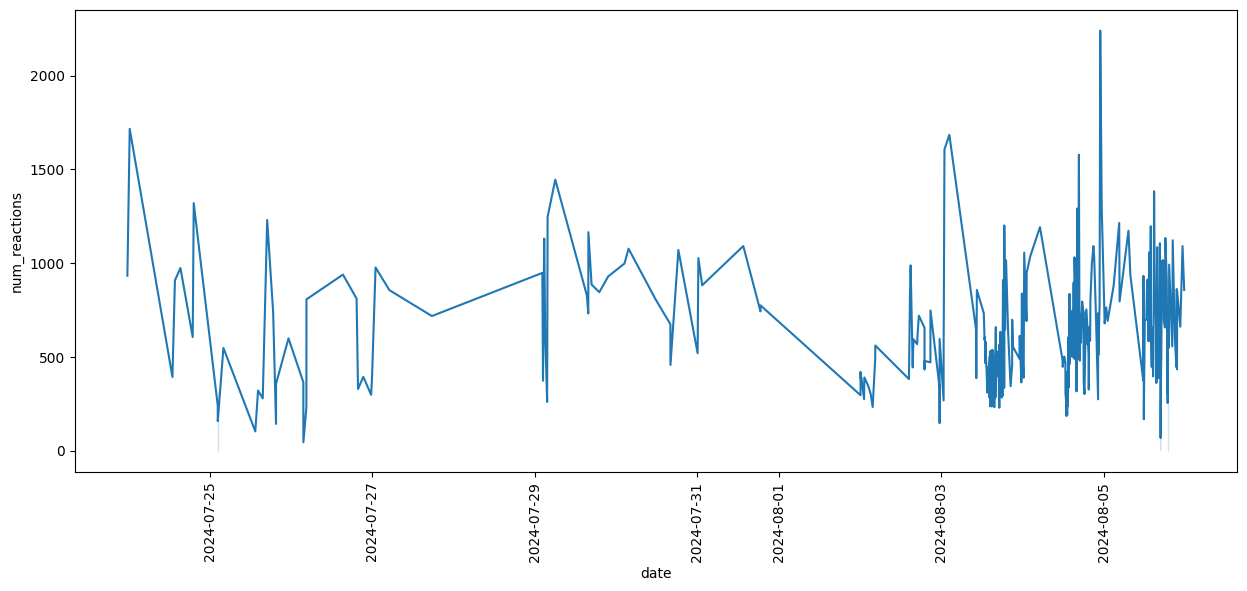

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.lineplot(x=result_df['date'], y=result_df['num_reactions'] )
plt.xticks(rotation=90,)

In [8]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, weighted_corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.040463  0.041219       1        1  38.736066
2     -0.017370 -0.053877       2        1  30.997194
1      0.057833  0.012658       3        1  30.266740, topic_info=             Term         Freq        Total Category  logprob  loglift
394    media_imag  1230.000000  1230.000000  Default  30.0000  30.0000
480          আপনা  2404.000000  2404.000000  Default  29.0000  29.0000
1810          লীগ   466.000000   466.000000  Default  28.0000  28.0000
751          পাচ্   273.000000   273.000000  Default  27.0000  27.0000
1465        হামলা   699.000000   699.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1169          সবা   279.088372  1172.285369   Topic3  -5.5323  -0.2401
280           সকল   304.404175  1574.730847   Topic3  -5.4455  -0.4484
334          শহীদ   193.456555   532.002658   Topic3  -5.8988   0.1835
308       univers   212.379435   830.274354   Topic3  -5.8054  -0.1683
395   media_video   217.493924   934.034133   Topic3  -5.7816  -0.2622

[287 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
288       1  0.212198   alert
288       2  0.532853   alert
288       3  0.254638   alert
1047      1  0.966674  alumni
1047      2  0.034524  alumni
...     ...       ...     ...
1130      2  0.813038   ১১.০০
1130      3  0.110242   ১১.০০
1131      1  0.051739   ️সকাল
1131      2  0.853696   ️সকাল
1131      3  0.103478   ️সকাল

[540 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [9]:
result_df_subset['text_plain'].str.contains('media_').sum()

103

In [10]:
len(result_df_subset)

394

In [11]:
result_df_subset['from'].value_counts()

from
PUSAB    394
Name: count, dtype: int64